In [41]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import lxml

# Define the path to your Excel file
file_path = '../src/data/ManualData_Mainstream.xlsx'

# Load the data initially without parsing dates
data = pd.read_excel(
    file_path,
    sheet_name="in",
    skiprows=4,      
    header=[0, 1, 2]
)
# Fill NaN rainfall with 0
data.loc[:, (slice(None), slice(None), 'RF')] = data.loc[:, (slice(None), slice(None), 'RF')].fillna(0)


In [42]:
data.set_index('StaName', inplace=True)

# Filter for "Stung Treng" measurements
bassac_caktomuk = data.loc[:, pd.IndexSlice['Bassac Chaktomuk', 33401, :]]

# Reset index to bring 'Date' back as a column
bassac_caktomuk.reset_index(inplace=True)
bassac_caktomuk.columns = bassac_caktomuk.columns.droplevel([0, 1])
bassac_caktomuk.columns = ['Date', 'WL 7AM', 'WL 7PM', 'RF']
bassac_caktomuk['Date'] = bassac_caktomuk['Date'].apply(lambda x: x[0] if isinstance(x, tuple) else x)
bassac_caktomuk['Date'] = pd.to_datetime(bassac_caktomuk['Date'])
bassac_caktomuk.set_index('Date', inplace=True)


bassac_caktomuk['WL 7AM'] = bassac_caktomuk['WL 7AM'].interpolate(method='linear')
bassac_caktomuk['WL 7PM'] = bassac_caktomuk['WL 7PM'].interpolate(method='linear')

/tmp/ipykernel_2424/3522240591.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bassac_caktomuk['Date'] = bassac_caktomuk['Date'].apply(lambda x: x[0] if isinstance(x, tuple) else x)
/tmp/ipykernel_2424/3522240591.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bassac_caktomuk['Date'] = pd.to_datetime(bassac_caktomuk['Date'])
/tmp/ipykernel_2424/3522240591.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [43]:
# Drop Columns
bassac_caktomuk = bassac_caktomuk.drop('WL 7PM', axis=1)
bassac_caktomuk = bassac_caktomuk.drop('RF', axis=1)

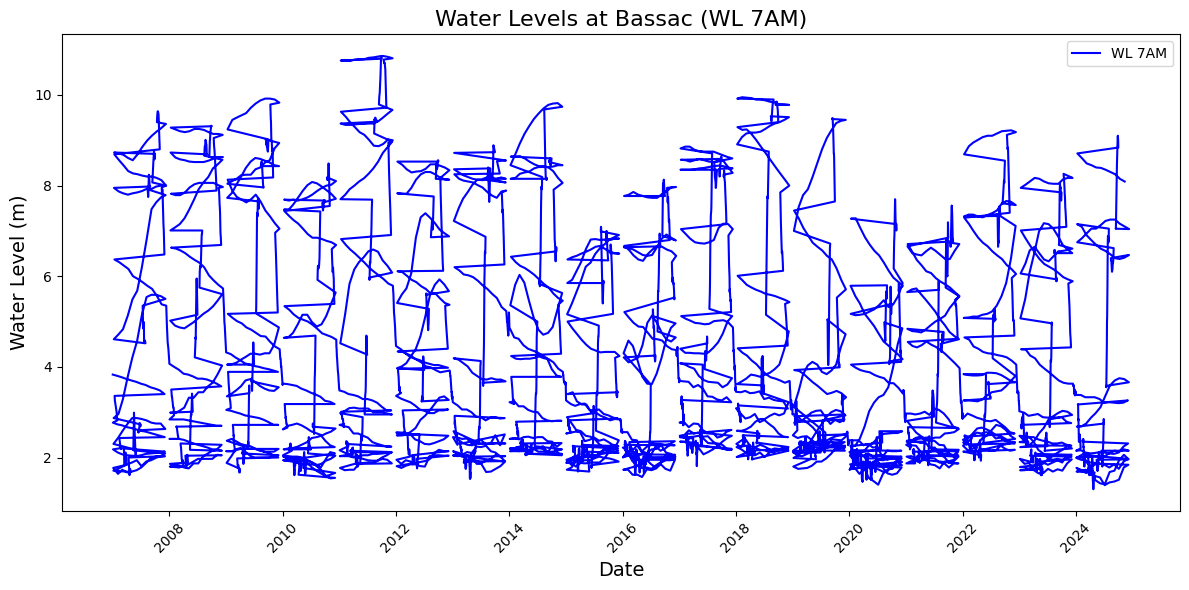

In [45]:
import matplotlib.pyplot as plt

# Plotting the water levels
plt.figure(figsize=(12, 6))
plt.plot(bassac_caktomuk.index, bassac_caktomuk['WL 7AM'], label='WL 7AM', color='blue')

# Adding title and labels
plt.title('Water Levels at Bassac (WL 7AM)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Water Level (m)', fontsize=14)

# Adding legend
plt.legend()

# Formatting date axis for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


# Train

In [46]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

# Split 2016-2024 For Training and 2024-End for testing
train = bassac_caktomuk.iloc[:6000]
test = bassac_caktomuk.iloc[6000:]

# Scale the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)  # Fit on train and transform both train and test
scaled_test = scaler.transform(test)

# Create inputs and outputs for training and testing
# Use all features as input and WL 7AM as the output
X_train = scaled_train  # All features for training
y_train = scaled_train[:, 0]  # WL 7AM is the first column
X_test = scaled_test  # All features for testing
y_test = scaled_test[:, 0]  # WL 7AM is the first column

look_back = 30 # Number of previous time steps to consider for prediction
batch_size = 32  # Batch size

# Create TimeseriesGenerator for training and testing data
train_generator = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

# Build the LSTM model
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(look_back, scaled_train.shape[1])))
model.add(LSTM(100, return_sequences=True))
model.add(GRU(50))
model.add(Dense(1))  # Output layer for predicting WL 7AM
model.compile(optimizer='adam', loss='mse')

# Fit the model with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/100


/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - loss: 0.0317 - val_loss: 0.0043
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 9.8319e-04 - val_loss: 9.5905e-04
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 9.8339e-04 - val_loss: 7.5175e-04
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 7.8892e-04 - val_loss: 7.2426e-04
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 7.6689e-04 - val_loss: 0.0018
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.0014 - val_loss: 5.1534e-04
Epoch 10/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 5.4484e-04 - val_loss: 0.0013
Epoch 11/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 5.1175e-04 - val_loss

 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6468e-04

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0733e-04
Test Loss: 8.83085813256912e-05
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


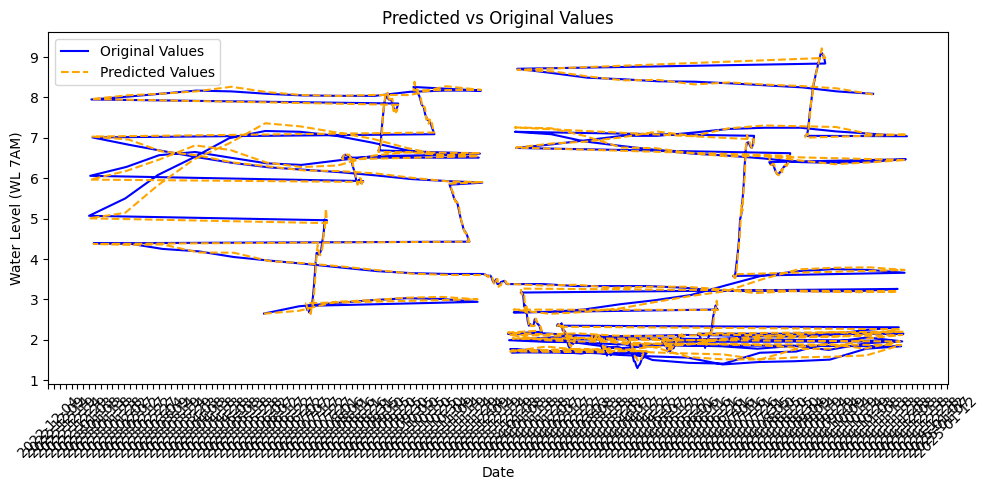

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Evaluate the model on test data
loss = model.evaluate(test_generator)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(test_generator)

# Inverse scale predictions to original values
# Reshape predictions to match the scaler input shape (for inverse scaling)
# Create an array with the same shape as the original data (3 columns)
predictions_reshaped = np.zeros((predictions.shape[0], 2))
predictions_reshaped[:, 0] = predictions.flatten()  # Place predictions in the first column

# Inverse scaling for predictions
predictions_inverse = scaler.inverse_transform(predictions_reshaped)

# Extract the WL 7AM column from the inverse transformed predictions
predictions_inverse_wl_7am = predictions_inverse[:, 0]

# The original scaled test data should also be reshaped to only include WL 7AM for comparison
# Use only the first column which corresponds to WL 7AM
original_test_data_inverse = scaler.inverse_transform(scaled_test[look_back:, :])[:, 0]

# Create dates for the test set
test_dates = bassac_caktomuk.index[6000 + look_back:6000 + len(predictions) + look_back]

# Plot predicted vs original values with dates
plt.figure(figsize=(10, 5))
plt.plot(test_dates, original_test_data_inverse, label='Original Values', color='blue')
plt.plot(test_dates, predictions_inverse_wl_7am, label='Predicted Values', linestyle='dashed', color='orange')
plt.title('Predicted vs Original Values')
plt.xlabel('Date')
plt.ylabel('Water Level (WL 7AM)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend()
plt.tight_layout()
plt.show()


In [47]:
results_df = pd.DataFrame({
    'Date': test_dates,
    'Original Values': original_test_data_inverse,
    'Predicted Values': predictions_inverse_wl_7am
})

# Optionally, you can save the DataFrame to a CSV file
results_df.to_csv('predictions_vs_original.csv', index=False)

# Display the first few rows of the DataFrame
print(results_df.head(50))

         Date  Original Values  Predicted Values
0  2023-06-07             2.65          2.647924
1  2023-07-07             2.83          2.718947
2  2023-08-07             2.91          2.940292
3  2023-09-07             2.98          2.982336
4  2023-10-07             3.03          3.041994
5  2023-11-07             3.01          3.061947
6  2023-12-07             2.94          3.002717
7  2023-07-13             2.84          2.907078
8  2023-07-14             2.74          2.792736
9  2023-07-15             2.73          2.692503
10 2023-07-16             2.67          2.712848
11 2023-07-17             2.81          2.639961
12 2023-07-18             2.85          2.848614
13 2023-07-19             3.09          2.860704
14 2023-07-20             3.42          3.191755
15 2023-07-21             3.85          3.599865
16 2023-07-22             4.15          4.107780
17 2023-07-23             4.15          4.349351
18 2023-07-24             4.11          4.167189
19 2023-07-25       

In [30]:
df_rainfall_inference = df_rainfall.last('10D')
df_waterlevel_inference = df_waterlevel.last('10D')
new_data = df_waterlevel_inference.join(df_rainfall_inference, how='inner')


# Scale the new data
scaled_new_data = scaler.transform(new_data)
scaled_new_data.shape


# Initialize variables for forecasting
look_back = 10
num_days_to_forecast = 5
predicted_values = []

# Create a copy of the scaled new data to avoid modifying the original
scaled_data_for_forecast = scaled_new_data.copy()

for i in range(num_days_to_forecast):
    # Use the last 'look_back' steps to predict the next water level
    input_data = scaled_data_for_forecast[-look_back:].reshape(1, look_back, 2)
    
    # Predict the next water level (scaled)
    predicted_scaled = model.predict(input_data)
    
    # Inverse transform the prediction (combine with 0 rainfall for inverse transform)
    predicted_water_level = scaler.inverse_transform(np.hstack([predicted_scaled, np.zeros((1, 1))]))[0, 0]
    
    # Append the predicted water level (not scaled) to the list
    predicted_values.append(predicted_water_level)
    
    # Update the scaled data for the next iteration
    # Create a new "scaled" row with the predicted water level and assume 0 rainfall
    new_row_scaled = np.hstack([predicted_scaled[0], 0]).reshape(1, -1)
    
    # Add this new row to the scaled data for the next prediction
    scaled_data_for_forecast = np.vstack([scaled_data_for_forecast, new_row_scaled])

# Print the predicted water levels for the next 7 days
for i, pred in enumerate(predicted_values):
    forecast_date = df_waterlevel_inference.index[-1] + pd.Timedelta(days=i+1)
    print(f"Predicted Water Level on {forecast_date}: {pred}")


NameError: name 'df_rainfall' is not defined